In [59]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import math
from scipy import optimize
import scipy.stats as stats
from scipy.stats import norm

# 1 Data Preprocessing

In [2]:
df = pd.read_excel('closing_price.xlsx')
time = df['Bloomberg Ticker']
data = df['AAPL UW Equity']
# time,data

In [3]:
apple_price = data.values
# apple_price

In [4]:
x = [(apple_price[i]-apple_price[i-1])/apple_price[i-1] for i in range(1, apple_price.shape[0])]
# x

In [5]:
learning_set_x = x[:len(x)*3//4]
testing_set_x  = x[len(x)*3//4:]
# len(learning_set_x),len(testing_set_x)

In [6]:
epsilon = np.mean(learning_set_x)
# epsilon

In [7]:
d = ['D' if i < -epsilon else 'U' if i > epsilon else 'H' for i in x]
# d

In [8]:
learning_set = apple_price[:len(apple_price)*3//4]
testing_set  = apple_price[len(apple_price)*3//4:]
# len(learning_set),len(testing_set)

# 2 Cumulative Distribution Function

In [9]:
Ux = [learning_set_x[i] for i in range(len(learning_set_x)-1) if d[i+1] == 'U' ]
Dx = [learning_set_x[i] for i in range(len(learning_set_x)-1) if d[i+1] == 'D' ]

In [58]:
FU = sorted(Ux)
val, cnt = np.unique(Ux, return_counts=True)
pmf = cnt/len(Ux)
FU_rv_discrete = stats.rv_discrete(name='fs_rv_dist', values=(val, pmf))

In [12]:
stats.rv_discrete??

Text(0.5, 1.0, 'CDF $F_U(x)$')

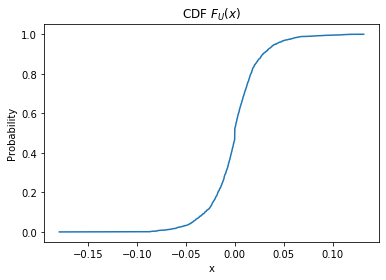

In [59]:
plt.plot(val, FU_rv_discrete.cdf(val), '-')
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('CDF $F_U(x)$')

In [60]:
FD = sorted(Dx)
val, cnt = np.unique(Dx, return_counts=True)
pmf = cnt/len(Dx)
FD_rv_discrete = stats.rv_discrete(name='fs_rv_dist', values=(val, pmf))

Text(0.5, 1.0, 'CDF $F_D(x)$')

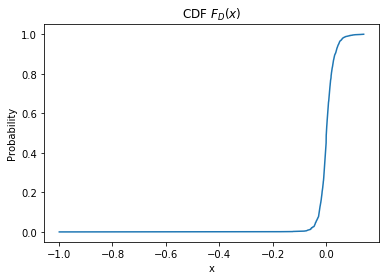

In [61]:
plt.plot(val, FD_rv_discrete.cdf(val), '-')
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('CDF $F_D(x)$')

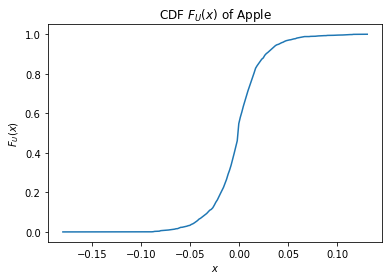

In [38]:
count,low,binsize,_=stats.cumfreq(Ux, numbins=200)
cdf_U_x=[]
cdf_U_x.append(low)
for i in range(1,200):
    cdf_U_x.append(cdf_U_x[i-1]+binsize)
cdf_U=[]
for i in range(200):
    cdf_U.append(count[i]/len(Ux))

# plt.figure(figsize=(12,8))
plt.plot(cdf_U_x,cdf_U)
plt.title('CDF $F_U(x)$ of Apple')
plt.ylabel('$F_U(x)$')
plt.xlabel('$x$')
plt.savefig('FU(x)')
plt.show()

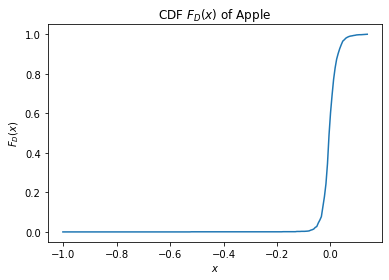

In [39]:
count,low,binsize,_=stats.cumfreq(Dx, numbins=200)
cdf_D_x=[]
cdf_D_x.append(low)
for i in range(1,200):
    cdf_D_x.append(cdf_D_x[i-1]+binsize)
cdf_D=[]
for i in range(200):
    cdf_D.append(count[i]/len(Dx))

# plt.figure(figsize=(12,8))
plt.plot(cdf_D_x,cdf_D)
plt.title('CDF $F_D(x)$ of Apple')
plt.ylabel('$F_D(x)$')
plt.xlabel('$x$')
plt.savefig('FD(x)')
plt.show()

# 3.Probability Density Function

In [40]:
def FD_distribution(x, b, x0):
    return 1/(1+np.exp(-b*(x-x0)))
b_U, x0_U = optimize.curve_fit(FD_distribution, cdf_U_x, cdf_U)[0]
b_D, x0_D = optimize.curve_fit(FD_distribution, cdf_D_x, cdf_D)[0]
b_U, x0_U, b_D, x0_D

(78.48745867173305,
 -0.0013810865566377369,
 76.35996040877227,
 -0.003778059399271094)

In [43]:
F_U=[]
for i in cdf_U_x:
    F_U.append(FD_distribution(i,78.48745867173305,-0.0013810865566377369))
F_D=[]
for i in cdf_D_x:
    F_D.append(FD_distribution(i,76.35996040877227,-0.003778059399271094))

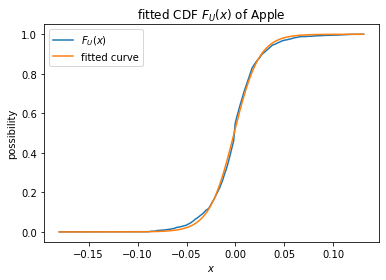

In [44]:
plt.plot(cdf_U_x,cdf_U,label="$F_U(x)$")
plt.plot(cdf_U_x,F_U,label="fitted curve")
plt.title('fitted CDF $F_U(x)$ of Apple')
plt.ylabel('possibility')
plt.xlabel('$x$')
plt.legend()
plt.savefig('FU(x) fitted')
plt.show()

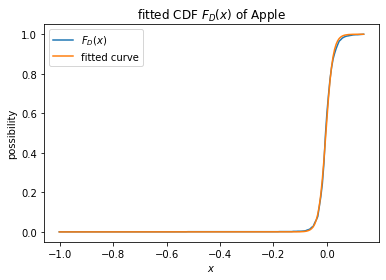

In [46]:
plt.plot(cdf_D_x,cdf_D,label="$F_D(x)$")
plt.plot(cdf_D_x,F_D,label="fitted curve")
plt.title('fitted CDF $F_D(x)$ of Apple')
plt.ylabel('possibility')
plt.xlabel('$x$')
plt.legend()
plt.savefig('FD(x) fitted')
plt.show()

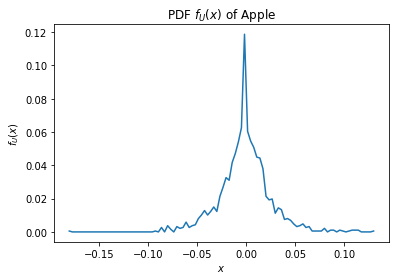

In [128]:
count,low,binsize,_=stats.relfreq(Ux, numbins=100)
pdf_U_x=[]
pdf_U_x.append(low)
for i in range(1,100):
    pdf_U_x.append(pdf_U_x[i-1]+binsize)
pdf_U=[]
for i in range(100):
    pdf_U.append(count[i])

# plt.figure(figsize=(12,8))
plt.plot(pdf_U_x,pdf_U)
plt.title('PDF $f_U(x)$ of Apple')
plt.ylabel('$f_U(x)$')
plt.xlabel('$x$')
plt.savefig('fU(x)')
plt.show()

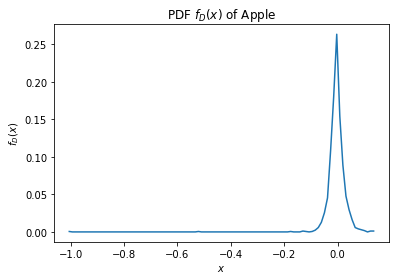

In [129]:
count,low,binsize,_=stats.relfreq(Dx, numbins=100)
pdf_D_x=[]
pdf_D_x.append(low)
for i in range(1,100):
    pdf_D_x.append(pdf_D_x[i-1]+binsize)
pdf_D=[]
for i in range(100):
    pdf_D.append(count[i])

plt.plot(pdf_D_x,pdf_D)
plt.title('PDF $f_D(x)$ of Apple')
plt.ylabel('$f_D(x)$')
plt.xlabel('$x$')
plt.savefig('fD(x)')
plt.show()

In [104]:
def Gaussian_distribution(x, u, epsilon):
    return np.exp(-(x-u)*(x-u)/(2*epsilon**2))/np.sqrt(2*np.pi*epsilon**2)

In [120]:
mean_U,std_U=np.mean(pdf_U),np.sqrt(sum((pdf_U-mean_U)**2)/(len(Ux)-1))
mean_D,std_D=np.mean(pdf_D),np.sqrt(sum((pdf_D-mean_D)**2)/(len(Dx)-1))
mean_U, std_U, mean_D, std_D

(0.01, 0.004376669636367765, 0.01, 0.009060721955589105)

In [124]:
f_U=[]
for i in pdf_U_x:
    f_U.append(Gaussian_distribution(i,0.01, 0.004376669636367765))
f_D=[]
for i in pdf_D_x:
    f_D.append(Gaussian_distribution(i,0.01, 0.009060721955589105))

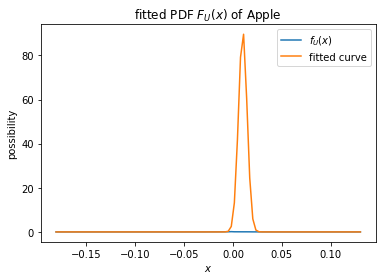

In [125]:
plt.plot(pdf_U_x,pdf_U,label="$f_U(x)$")
plt.plot(pdf_U_x,f_U,label="fitted curve")
plt.title('fitted PDF $F_U(x)$ of Apple')
plt.ylabel('possibility')
plt.xlabel('$x$')
plt.legend()
plt.savefig('fU(x) fitted')
plt.show()

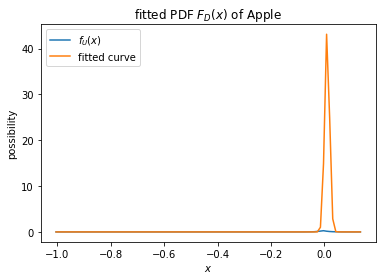

In [126]:
plt.plot(pdf_D_x,pdf_D,label="$f_U(x)$")
plt.plot(pdf_D_x,f_D,label="fitted curve")
plt.title('fitted PDF $F_D(x)$ of Apple')
plt.ylabel('possibility')
plt.xlabel('$x$')
plt.legend()
plt.savefig('fD(x) fitted')
plt.show()